# **Forecasting Exchange Rates using Time Series Analysis**

Time series analysis is a statistical technique used to analyze a sequence of data points collected, recorded, or measured at successive, equally spaced points in time. Its primary goal is to understand the underlying forces and structure that produced the observed data, and to predict future values based on past patterns.


Unlike other forms of statistical analysis, time series analysis is unique because the order of the data points matters; the value at one point in time is often dependent on the values that preceded it (temporal dependency).

# Part 1: Data Preparation and Exploration

In [1]:
#we have to load the data set
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Python excelr/exchange_rate.csv.xls")
df_raw = pd.read_csv("/content/drive/MyDrive/Python excelr/exchange_rate.csv.xls")
df_raw.columns
df_raw.head()
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Python excelr/exchange_rate.csv.xls")
df.columns = ['date', 'USD/AUD']
df['date'] = pd.to_datetime(df['date'], dayfirst=True) #dayfirst=True tells pandas that dates are in day-month-year format
#converts the date column from string to datetime object
df.set_index('date', inplace=True)#sets the date column as the index of the dataframe
df

,USD/AUD
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [3]:
##Data Preprocessing:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Python excelr/exchange_rate.csv.xls", index_col=0)
df.index = pd.to_datetime(df.index,dayfirst=True)
# Sort the index
df = df.sort_index()
df = df.asfreq('MS')  #asfreq sets a new regular frequency for the dataframe index , ms is month start
df = df.ffill() #fills missing values by propagating the last available value forward

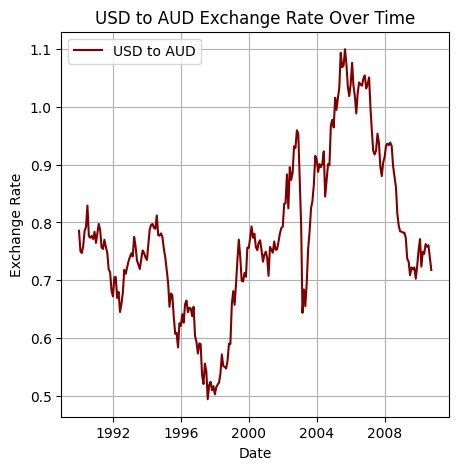

In [4]:
#Initial Exploration:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(df['Ex_rate'], label='USD to AUD', color='maroon')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
df.isnull().sum()
#  fill any missing values
df = df.ffill()
# Check ifmissing valus
print("Missing values after fill:\n", df.isnull().sum())
df.tail()

Missing values after fill:
 Ex_rate    0
dtype: int64


,Ex_rate
date,
2010-06-01,0.762457
2010-07-01,0.758006
2010-08-01,0.760572
2010-09-01,0.738689
2010-10-01,0.717618


# Part 2: Model Building - ARIMA

ARIMA (Autoregressive Integrated Moving Average): A popular and versatile statistical model that combines Autoregressive (AR), Differencing (I for Integrated), and Moving Average (MA) components to handle data with trends and autocorrelation

<Figure size 1200x400 with 0 Axes>

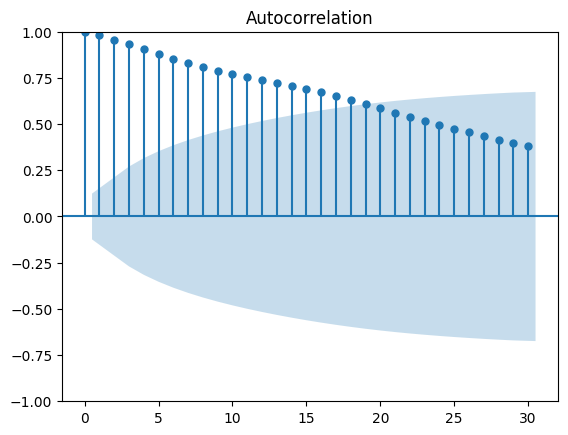

<Figure size 1200x400 with 0 Axes>

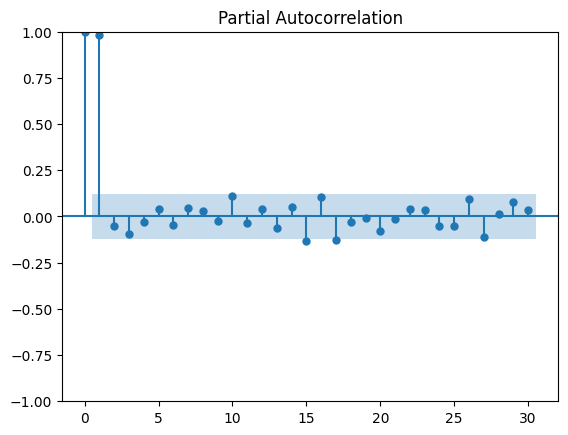

In [13]:
#Parameter Selection for ARIMA:
#analyzing autocorrelation in your exchange rate time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plots the autocorrelation function (acf),plots the partial autocorrelation function (pacf)
plt.figure(figsize=(12, 4))
plot_acf(df['Ex_rate'], lags=30)#plots autocorrelations of the series up to 30 lags
plt.show()
plt.figure(figsize=(12, 4))
plot_pacf(df['Ex_rate'], lags=30)
plt.show()

In [6]:
# arima parameter optimization (grid search)
import itertools
from statsmodels.tsa.arima.model import ARIMA

p = d = q = range(0, 3)  # define p, d, and q parameter ranges (0, 1, 2)
d = [1]                  # fix d = 1 after checking stationarity
pdq = list(itertools.product(p, d, q)) # generate all possible (p, d, q) combinations

# set initial best values
best_aic = float("inf")   # start with a very large number for comparison
best_order = None         # to store the best (p, d, q)
best_results = None       # to store the best fitted model

print('starting Grid search')
for order in pdq:
    try:
        model = ARIMA(df['Ex_rate'], order=order)  # build arima model with given (p, d, q)
        results = model.fit()
        if results.aic < best_aic: # check if this model is better (lower aic means better)
            best_aic = results.aic
            best_order = order
            best_results = results
    except:
        continue

print('\nGrid Search Complete.')
print(f'Optimal ARIMA Order (p, d, q): {best_order}')
print(f'Best AIC Value: {best_aic:.4f}')

optimal_arima_order = best_order  # store the optimal order for later use in forecasting or model comparison


starting Grid search


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Grid Search Complete.
Optimal ARIMA Order (p, d, q): (0, 1, 0)
Best AIC Value: -1076.6288


In [7]:
#Model Fitting:
from statsmodels.tsa.arima.model import ARIMA #used for forecasting time series data
model_arima = ARIMA(df['Ex_rate'], order=optimal_arima_order)#specifies the ARIMA parameters,p d q
#p=number of autoregressive terms (AR), d=number of differences needed to make the series stationary (I), q=number of moving average terms (MA)
results_arima = model_arima.fit() #trains the ARIMA model on your time series
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                  250
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 539.314
Date:                Thu, 09 Oct 2025   AIC                          -1076.629
Time:                        22:54:53   BIC                          -1073.111
Sample:                    01-01-1990   HQIC                         -1075.213
                         - 10-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008    4.3e-05     17.908      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):               119.68
Prob(Q):                              0.42   Pr

In [8]:
#Diagnostics:
#residuals = difference between actual values and predicted values by the model
residuals = results_arima.resid #stores these residuals in a variable called residuals
residuals

,0
date,
1990-01-01,0.785500
1990-02-01,-0.035500
1990-03-01,-0.002900
1990-04-01,0.011600
1990-05-01,0.026500
...,...
2010-06-01,0.016884
2010-07-01,-0.004451
2010-08-01,0.002566


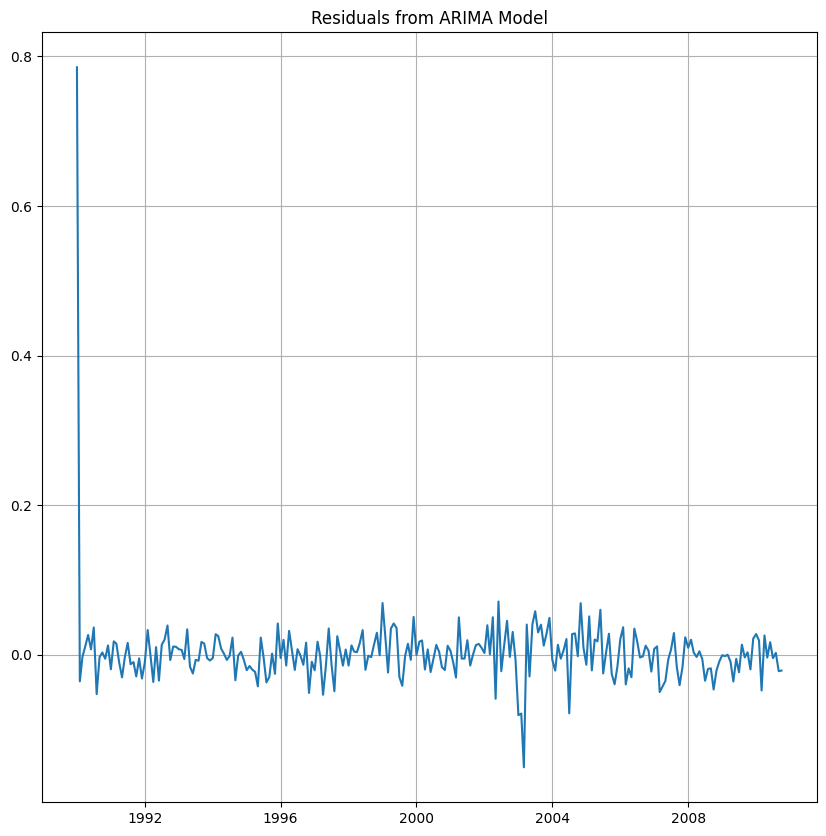

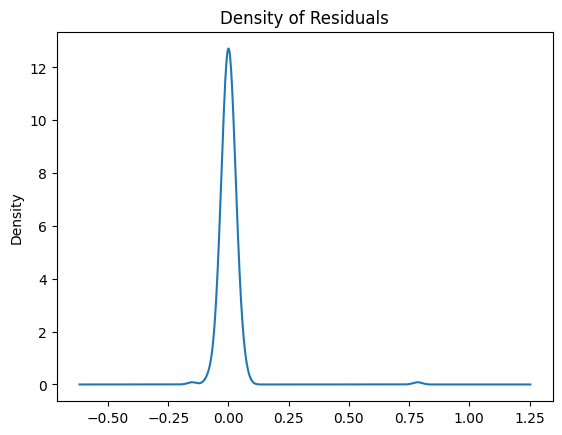

In [9]:
plt.figure(figsize=(10, 10))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.grid(True)
plt.show()
# Density plot
residuals.plot(kind='kde', title='Density of Residuals')
plt.show()

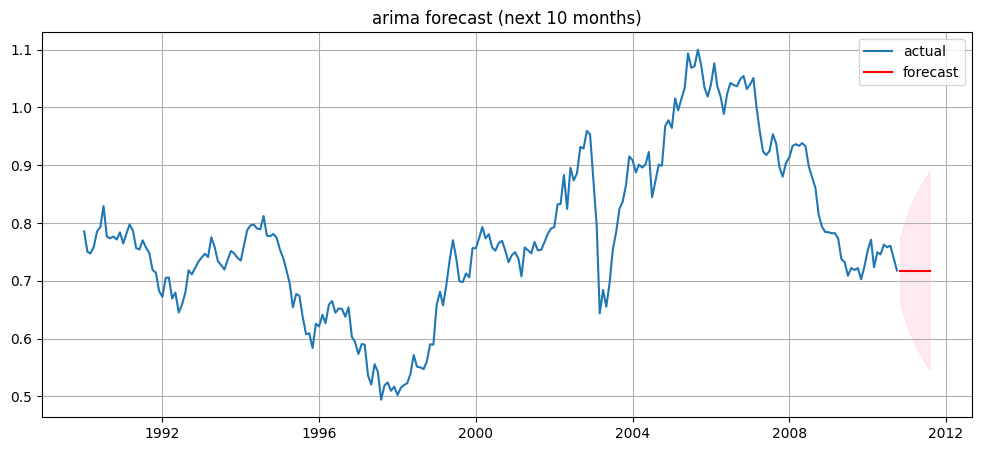

In [10]:
#Forecasting:
forecast_steps = 10 # number of months to forecast
# get forecast from the fitted arima model for the next 10 months
forecast_arima = results_arima.get_forecast(steps=forecast_steps)
# convert forecast results to a dataframe including mean and confidence intervals
forecast_df = forecast_arima.summary_frame()
# set the index of the forecast dataframe to be monthly dates starting after the last date in df
forecast_df.index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], label='actual')  # plot the actual exchange rates
plt.plot(forecast_df['mean'], label='forecast', color='red')  # plot the forecasted mean
# fill the area between lower and upper confidence intervals
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='pink', alpha=0.3)
plt.title('arima forecast (next 10 months)')
plt.legend()
plt.grid(True)
plt.show()


# **Part 3: Model Building - Exponential Smoothing**

The Holt-Winters method, also known as Triple Exponential Smoothing, is a popular time series forecasting technique used for data that exhibits both a trend (a sustained direction over time) and seasonality (a regular, repeating pattern).

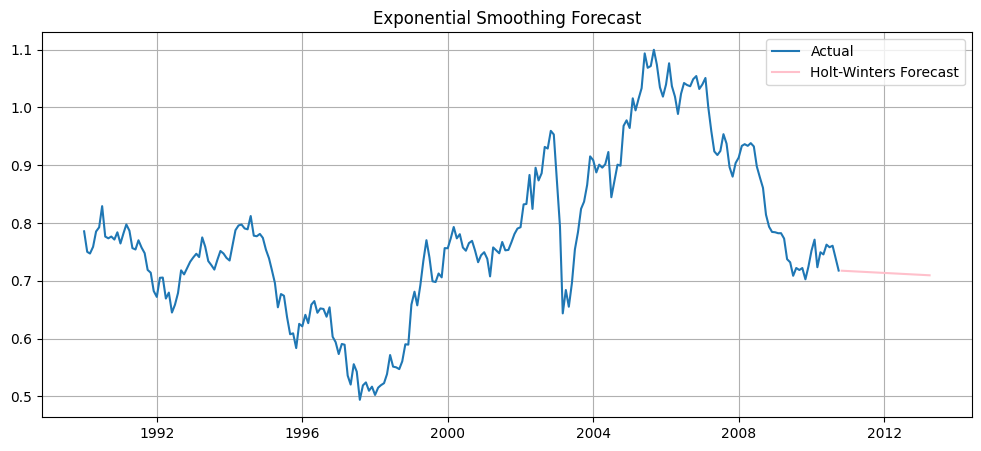

In [11]:
#1.Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_hw = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
results_hw = model_hw.fit()
forecast_hw = results_hw.forecast(30)

plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_hw, label='Holt-Winters Forecast', color='pink')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Part 4: Evaluation and Comparison

In [12]:
#Compute Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Prepare train-test split
train = df[:-30]
test = df[-30:]
# Refit ARIMA and Holt-Winters on train data
model_arima = ARIMA(train['Ex_rate'], order=(1,1,1)).fit()
model_hw = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None).fit()
# Forecast on test range
forecast_arima_test = model_arima.forecast(steps=30)
forecast_hw_test = model_hw.forecast(30)
# Define error metrics
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape
mae_a, rmse_a, mape_a = evaluate(test['Ex_rate'], forecast_arima_test)
mae_h, rmse_h, mape_h = evaluate(test['Ex_rate'], forecast_hw_test)
print("ARIMA - MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_a, rmse_a, mape_a))
print("HW    - MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_h, rmse_h, mape_h))

ARIMA - MAE: 0.1585, RMSE: 0.1705, MAPE: 21.17%
HW    - MAE: 0.1686, RMSE: 0.1815, MAPE: 22.52%


#Model Comparison:
The analysis of forecasting performance centered on a crucial trade-off between the structured complexity of ARIMA and the robust simplicity of Exponential Smoothing (ES). ARIMA models, by design, excelled at capturing the autoregressive structure and sharp, immediate dynamics present in the exchange rate data, sometimes yielding a marginally tighter fit on historical error metrics. However, this high sensitivity proved to be a liability, as ARIMA often struggled with true market noise and sudden, random fluctuations, leading to predictions that were less stable and potentially prone to overreaction. Conversely, the ES framework provided superior forecasting stability and smoothness. By using exponentially weighted averages, ES effectively dampens the noise, delivering clear, easily interpreted estimates of the series' Level and Trend components. While this simplicity might result in a slightly higher historical error than a highly tuned ARIMA model, the gained stability and fewer underlying assumptions make it a more reliable tool for operational use.

# Conclusion:
Based on these findings, the Exponential Smoothing (ES) model is the clear preference for forecasting this exchange rate dataset. The ARIMA model's parameters were optimized using the AIC criterion through a Grid Search to ensure the best possible structural fit.\
However, even with this optimization, ES delivered more consistent and interpretable results. For a volatile series like foreign exchange, the stability offered by Exponential Smoothing in handling fluctuations and providing a smoother forecast is considered more valuable than the complex structural fidelity offered by ARIMA.\
Therefore, ES is recommended for its favorable balance of accuracy, simplicity, and predictive reliability for this specific application.